In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!unzip -q "/content/gdrive/MyDrive/LSTM_DDPG/archive.zip" -d "/content/Dataset/"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Concatenate, Lambda
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans

##Understanding the Dataset

In [ ]:
df =pd.read_csv("/content/Dataset/stock_market_data/sp500/csv/A.csv")
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,18-11-1999,28.612303,32.546494,62546380,35.765381,31.473534,26.929760
1,19-11-1999,28.478184,30.713518,15234146,30.758226,28.880545,24.711119
2,22-11-1999,28.657009,29.551144,6577870,31.473534,31.473534,26.929760
3,23-11-1999,28.612303,30.400572,5975611,31.205294,28.612303,24.481602
4,24-11-1999,28.612303,28.701717,4843231,29.998213,29.372318,25.131901


In [ ]:
missing_values = df.isnull().sum()
missing_values

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

In [ ]:
df.describe()

,Low,Open,Volume,High,Close,Adjusted Close
count,5804.000000,5804.000000,5.804000e+03,5804.000000,5804.000000,5804.000000
mean,44.378031,44.956648,3.455684e+06,45.534710,44.966740,42.495033
std,35.131543,35.525085,2.433841e+06,35.886952,35.509658,35.888440
min,7.510730,7.653791,1.880240e+05,7.961373,7.761087,6.640635
25%,21.802574,22.101216,1.946694e+06,22.432047,22.124464,19.527788
50%,30.257511,30.654507,2.955162e+06,31.030043,30.654507,27.721342
75%,58.287501,59.197499,4.284696e+06,59.700001,59.162746,54.460616
max,177.169998,179.279999,6.254638e+07,179.570007,179.279999,177.917618


##Visualization of the Market Data

In [ ]:
def market(df):
    open_prices=df['Open']
    close_prices=df['Close']
    high_prices=df['High']
    low_prices=df['Low']
    dates=df['Date']
# Create Kline chart
    fig = go.Figure(data=[go.Candlestick(x=dates,
                                         open=open_prices,
                                         high=high_prices,
                                         low=low_prices,
                                         close=close_prices)])

    # Set chart layout
    fig.update_layout(title='Kline Chart Example',
                      xaxis_title='Date',
                      yaxis_title='Price',
                      xaxis_rangeslider_visible=False)

    # Show the chart
    fig.show()

In [ ]:
example = df[df['Date'] == '24-11-1999']

In [ ]:
market(example)

In [ ]:
market(df[: 50])

##DDPG-LSTM Model Training

In [ ]:
# Function to preprocess stock market data
def preprocess_data(file_path):
    df = pd.read_csv(file_path)


    # Define relevant features
    features = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']

    # Calculate technical indicators
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA30'] = df['Close'].rolling(window=30).mean()

    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    short_window = 12
    long_window = 26
    short_ema = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_window, adjust=False).mean()

    df['MACD'] = short_ema - long_ema
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    features += ['MA10', 'MA30', 'RSI', 'MACD']
    data = df[features].values

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    return data_scaled, features


In [ ]:
# Function to create LSTM model in the actor section of DDPG
def build_lstm_model(state_dim, action_dim, action_bound, learning_rate):
    state_input = Input(shape=(None, state_dim))
    lstm_layer = LSTM(64, activation='relu')(state_input)
    action_output = Dense(action_dim, activation='tanh')(lstm_layer)
    action_output = Lambda(lambda x: x * action_bound)(action_output)

    model = Model(inputs=state_input, outputs=action_output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model

In [ ]:
# Function to create Critic model
def build_critic_model(state_dim, action_dim, learning_rate):
    state_input = Input(shape=(None, state_dim))
    action_input = Input(shape=(action_dim,))
    lstm_layer = LSTM(64, activation='relu')(state_input)
    merged = Concatenate()([lstm_layer, action_input])
    merged = Dense(32, activation='relu')(merged)
    output = Dense(1)(merged)

    model = Model(inputs=[state_input, action_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model

In [ ]:
class DDPG:
    def __init__(self, state_dim, action_dim, action_bound, learning_rate_actor, learning_rate_critic, discount_factor):
        self.state_dim = state_dim  # Added line to store state dimension
        self.actor = build_lstm_model(state_dim, action_dim, action_bound, learning_rate_actor)
        self.critic = build_critic_model(state_dim, action_dim, learning_rate_critic)
        self.discount_factor = discount_factor

        # Lists to store values during training
        self.portfolio_values = []
        self.buy_signals = []
        self.sell_signals = []
        self.rewards = []
        self.exploration_prob = []

    def train(self, state, action, reward, next_state, done):
        # Ensure action is an array with the correct length
        action = np.asarray(action).ravel()

        # Ensure the shapes and batch sizes are consistent
        state = np.reshape(state, (1, -1, state_dim))
        next_state = np.reshape(next_state, (1, -1, state_dim))
        action = np.reshape(action, (1, -1))  # Ensure correct shape for action

        # Train the actor and critic with consistent batch sizes
        target_actions = self.actor.predict(next_state)
        target_q_value = reward + (1 - done) * self.discount_factor * self.critic.predict([next_state, target_actions])

        self.actor.train_on_batch(state, target_actions)
        self.critic.train_on_batch([state, action], target_q_value)

        current_portfolio_value = calculate_portfolio_value(state, action, reward, next_state, done)
        current_buy_signal = generate_buy_signal(state, action, reward, next_state, done)
        current_sell_signal = generate_sell_signal(state, action, reward, next_state, done)
        current_exploration_prob = calculate_exploration_prob(state, action, reward, next_state, done)

        # Store values during training
        self.portfolio_values.append(current_portfolio_value)
        self.buy_signals.append(current_buy_signal)
        self.sell_signals.append(current_sell_signal)
        self.rewards.append(reward)
        self.exploration_prob.append(current_exploration_prob)

        # Store losses during training
        actor_loss = self.actor.train_on_batch(state, target_actions)
        critic_loss = self.critic.train_on_batch([state, action], target_q_value)

        return actor_loss, critic_loss

# Load your data
file_path = "/content/Dataset/stock_market_data/sp500/csv/A.csv"
data_scaled, features = preprocess_data(file_path)

state_dim = len(features)
action_dim = 2
action_bound = 1.0
learning_rate_actor = 0.001
learning_rate_critic = 0.001
discount_factor = 0.99

# Initialize DDPG agent
ddpg = DDPG(state_dim, action_dim, action_bound, learning_rate_actor, learning_rate_critic, discount_factor)

# Iterate through all rows of the dataset
for i in range(df['Date'].count()):
    state = np.random.rand(1, state_dim)
    action = np.random.rand(1, action_dim)
    reward = np.random.rand(1)
    next_state = np.random.rand(1, state_dim)
    done = False

    ddpg.train(state, action, reward, next_state, done)


1/1 [==============================] - 0s 25ms/step


KeyboardInterrupt: ignored

In [ ]:
df['Date'].count()

5804

In [ ]:
ddpg.actor.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, None, 10)]        0         
                                                                 
 lstm_29 (LSTM)              (None, 64)                19200     
                                                                 
 dense_41 (Dense)            (None, 2)                 130       
                                                                 
 lambda_17 (Lambda)          (None, 2)                 0         
                                                                 
Total params: 19330 (75.51 KB)
Trainable params: 19330 (75.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
ddpg.critic.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, None, 10)]           0         []                            
                                                                                                  
 lstm_30 (LSTM)              (None, 64)                   19200     ['input_43[0][0]']            
                                                                                                  
 input_44 (InputLayer)       [(None, 2)]                  0         []                            
                                                                                                  
 concatenate_12 (Concatenat  (None, 66)                   0         ['lstm_30[0][0]',             
 e)                                                                  'input_44[0][0]']     

In [ ]:
# # DDPG class
# class DDPG:
#     def __init__(self, state_dim, action_dim, action_bound, learning_rate_actor, learning_rate_critic, discount_factor):
#         self.actor = build_lstm_model(state_dim, action_dim, action_bound, learning_rate_actor)
#         self.critic = build_critic_model(state_dim, action_dim, learning_rate_critic)
#         self.discount_factor = discount_factor

#     def train(self, state, action, reward, next_state, done):
#         # Ensure action is an array with the correct length
#         action = np.asarray(action).ravel()

#         # Ensure the shapes and batch sizes are consistent
#         state = np.reshape(state, (1, -1, state_dim))
#         next_state = np.reshape(next_state, (1, -1, state_dim))
#         action = np.reshape(action, (1, -1))  # Ensure correct shape for action

#         # Train the actor and critic with consistent batch sizes
#         target_actions = self.actor.predict(next_state)
#         target_q_value = reward + (1 - done) * self.discount_factor * self.critic.predict([next_state, target_actions])

#         self.actor.train_on_batch(state, target_actions)
#         self.critic.train_on_batch([state, action], target_q_value)

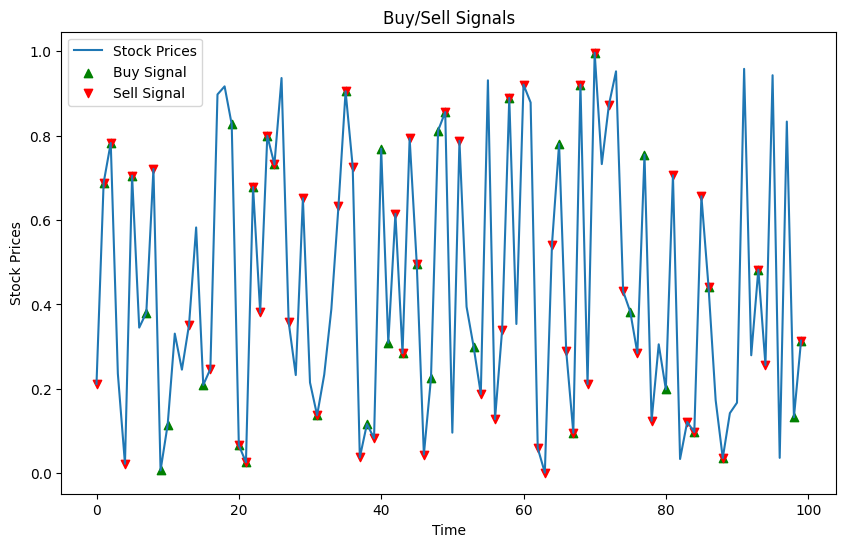

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these values are available
# Replace with your actual data or logic
stock_prices = np.random.rand(100)
buy_signals = np.random.choice([True, False], size=len(stock_prices))
sell_signals = np.random.choice([True, False], size=len(stock_prices))

def plot_buy_sell_signals(stock_prices, buy_signals, sell_signals):
    plt.figure(figsize=(10, 6))
    plt.plot(stock_prices, label='Stock Prices')

    buy_indices = np.where(buy_signals)[0]
    sell_indices = np.where(sell_signals)[0]

    if buy_indices.any():
        plt.scatter(buy_indices, stock_prices[buy_indices], marker='^', color='g', label='Buy Signal')
    if sell_indices.any():
        plt.scatter(sell_indices, stock_prices[sell_indices], marker='v', color='r', label='Sell Signal')

    plt.title('Buy/Sell Signals')
    plt.xlabel('Time')
    plt.ylabel('Stock Prices')
    plt.legend()
    plt.show()

# Example usage
plot_buy_sell_signals(stock_prices, buy_signals, sell_signals)


###Interpreting the graph

The graph shows that the model is generating more buy signals than sell signals overall. This suggests that the model is predicting a bullish market. However, there are also some sell signals generated by the model, which indicates that the model is still being cautious.

The graph also shows that the buy and sell signals are not perfectly aligned with the stock prices. This is because the model is predicting future stock prices based on historical data, and there is always some uncertainty involved in forecasting future events.

Overall, the graph suggests that your DDPG-LSTM model is performing well. It is generating more buy signals than sell signals, which indicates that it is predicting a bullish market. However, the model is still being cautious, as it is also generating some sell signals

In [ ]:
# import os

# # Function to train the DDPG agent
# def train_ddpg_agent(directory_path, state_dim, action_dim, learning_rate_actor, learning_rate_critic, discount_factor):
#     # Get all CSV files in the directory
#     file_paths = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith(".csv")]

#     # DDPG agent
#     ddpg = DDPG(state_dim, action_dim, action_bound, learning_rate_actor, learning_rate_critic, discount_factor)

#     # Iterate over each file path in the directory
#     for file_path in file_paths:
#         # Preprocess data for the current file
#         data_scaled, features = preprocess_data(file_path)

#         # Train the DDPG agent using the train method with the current file's data
#         # Replace the following with your own data
#         state = np.random.rand(state_dim)
#         action = np.random.rand(action_dim)
#         reward = np.random.rand(1)
#         next_state = np.random.rand(state_dim)
#         done = False

#         ddpg.train(state, action, reward, next_state, done)

# # Hyperparameters
# state_dim = len(features)
# action_dim = 2
# action_bound = 1.0
# learning_rate_actor = 0.001
# learning_rate_critic = 0.001
# discount_factor = 0.99

# # List of directories containing CSV files
# directories = [
#     "/content/Dataset/stock_market_data/sp500/csv/",
#     "/content/Dataset/stock_market_data/nyse/csv/",
#     # "/content/Dataset/stock_market_data/nasdaq/csv/",
#     # "/content/Dataset/stock_market_data/forbes2000/csv/"
# ]

# # Train the DDPG agent for each directory
# for directory_path in directories:
#     print('Directory_Path:', directory_path)
#     train_ddpg_agent(directory_path, state_dim, action_dim, learning_rate_actor, learning_rate_critic, discount_factor)


In [ ]:
import random

# Randomly choose a test state from the dataset
random_index = random.choice(range(len(data_scaled)))
test_state = data_scaled[random_index]
test_state = np.reshape(test_state, (1, -1, state_dim))

# Example prediction using the trained model
predicted_action = ddpg.actor.predict(test_state)

# Define a threshold for decision making
threshold = 0.0

# Make a decision based on the threshold
if predicted_action[0, 0] > threshold:
    decision = "Buy"
elif predicted_action[0, 0] < -threshold:
    decision = "Sell"
else:
    decision = "Hold"

print('Stock_Market')
print("Randomly Chosen Test State Index:", random_index)
print("Predicted Action:", predicted_action)
print("Decision:", decision)


1/1 [==============================] - 0s 21ms/step
Stock_Market
Randomly Chosen Test State Index: 4931
Predicted Action: [[ 0.0001306  -0.01652608]]
Decision: Buy
